In [43]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [44]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [45]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(torch.exp(output))

tensor([[0.0560, 0.0496, 0.0546, 0.0545, 0.0564, 0.0536, 0.0521, 0.0539, 0.0614,
         0.0562, 0.0547, 0.0539, 0.0599, 0.0554, 0.0585, 0.0595, 0.0537, 0.0563]],
       grad_fn=<ExpBackward0>)


In [46]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 8)


In [47]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Safar
category = Spanish / line = Blanxart
category = Irish / line = O'Sullivan
category = Vietnamese / line = Thao
category = Korean / line = Sin
category = Dutch / line = Vandroogenbroeck
category = Chinese / line = Peng
category = Irish / line = Mcneil
category = Korean / line = Choi
category = Vietnamese / line = Thai


In [48]:
print(rnn)
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [49]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.4689 Hamilton / Greek ✗ (Scottish)
10000 10% (0m 16s) 2.1608 Castro / Italian ✗ (Portuguese)
15000 15% (0m 24s) 1.8840 Delgado / Italian ✗ (Spanish)
20000 20% (0m 33s) 0.3490 Sakelaris / Greek ✓
25000 25% (0m 41s) 1.4810 Faucheux / French ✓
30000 30% (0m 49s) 2.9431 Rojas / Greek ✗ (Spanish)
35000 35% (0m 57s) 2.1167 Ramaker / German ✗ (Dutch)
40000 40% (1m 5s) 0.8028 Guo / Chinese ✓
45000 45% (1m 13s) 3.6914 Lachapelle / Irish ✗ (French)
50000 50% (1m 22s) 1.6481 Qureshi / Italian ✗ (Arabic)
55000 55% (1m 30s) 2.6295 Russell / English ✗ (Scottish)
60000 60% (1m 38s) 0.4019 Ly / Vietnamese ✓
65000 65% (1m 46s) 0.0551 Kasaya / Japanese ✓
70000 70% (1m 54s) 1.7855 Krol / Scottish ✗ (Polish)
75000 75% (2m 2s) 0.4083 Maalouf / Arabic ✓
80000 80% (2m 11s) 0.7644 Campos / Portuguese ✓
85000 85% (2m 19s) 0.4628 Yoon / Korean ✓
90000 90% (2m 27s) 0.2599 Zaskokin / Russian ✓
95000 95% (2m 34s) 0.9169 Treasach / Irish ✓
100000 100% (2m 42s) 0.0400 Agelakos / Greek ✓


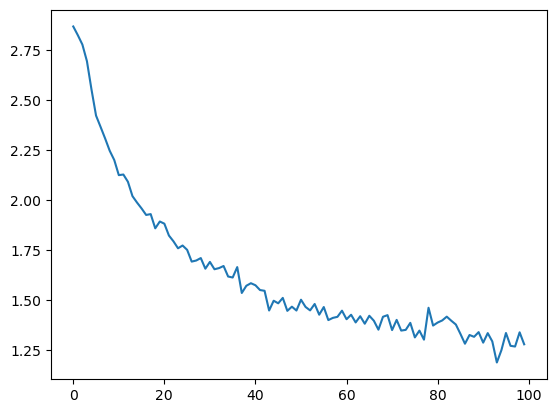

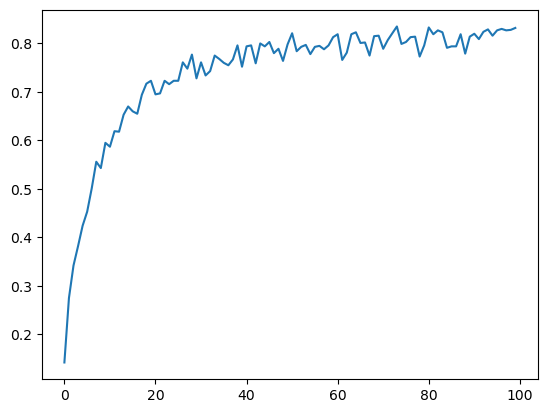

In [53]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.figure()
plt.plot(all_accurancy)

C:\Users\86151\AppData\Local\Temp\ipykernel_10808\3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\86151\AppData\Local\Temp\ipykernel_10808\3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


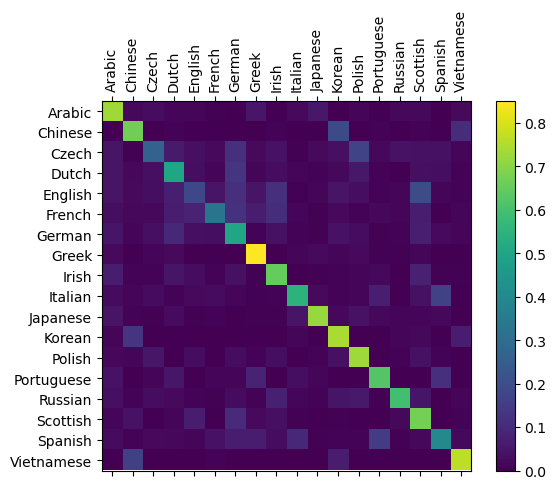

In [51]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [52]:
import math
import numpy as np

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (np.exp(value), all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Hou')


> Dovesky
(0.84) Russian
(0.07) Czech
(0.03) English

> Jackson
(0.63) Scottish
(0.15) Russian
(0.13) English

> Hou
(0.40) Chinese
(0.39) Korean
(0.14) Vietnamese


In [8]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('D:/dasanxia/shenduxuexi/2111033/data1/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('D:/dasanxia/shenduxuexi/2111033/data1/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['D:/dasanxia/shenduxuexi/2111033/data1/names\\Arabic.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\Chinese.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\Czech.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\Dutch.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\English.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\French.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\German.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\Greek.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\Irish.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\Italian.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\Japanese.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\Korean.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\Polish.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\Portuguese.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\Russian.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\Scottish.txt', 'D:/dasanxia/shenduxuexi/2111033/data1/names\\S

In [9]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [10]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

D:\newapp\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [11]:
import torch.nn as nn
n_hidden = 128

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, h, c):
        input = input.view(len(input), 1, -1)
        out, (h, c) = self.rnn(input, (h, c))
        output = self.out(out.view(len(input), -1))
        output = self.softmax(output)
        return output, h, c

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)

In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Masudu
category = English / line = Mawson
category = Czech / line = Kenzel
category = Japanese / line = Haga
category = Arabic / line = Asghar
category = Irish / line = Tracey
category = Japanese / line = Masaoka
category = Portuguese / line = Barros
category = Japanese / line = Arihyoshi
category = Vietnamese / line = Lam


In [15]:
criterion = nn.NLLLoss()
learning_rate = 0.05

In [16]:
n_hidden = 128
rnn = LSTM(n_letters, n_hidden, n_categories)
print(rnn)

LSTM(
  (rnn): LSTM(57, 128)
  (out): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [17]:
def train(category_tensor, line_tensor):
    h, c = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, h, c = rnn(line_tensor[i], h, c)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [18]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_accurancy = []
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [19]:
start = time.time()
correct_num = 0
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        correct_num += 1
        
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accurancy.append(correct_num / plot_every)
        correct_num = 0

5000 5% (0m 26s) 2.8816 Lynn / Chinese ✗ (English)
10000 10% (0m 51s) 2.9351 Bonnay / Irish ✗ (French)
15000 15% (1m 19s) 0.8741 Selvaggio / Italian ✓
20000 20% (1m 45s) 2.9153 Mckay / Scottish ✗ (Irish)
25000 25% (2m 10s) 1.9805 Omori / Italian ✗ (Japanese)
30000 30% (2m 35s) 1.1403 Kistner / German ✓
35000 35% (3m 0s) 3.9650 Rey / Korean ✗ (Spanish)
40000 40% (3m 25s) 1.4724 Paget / German ✗ (French)
45000 45% (3m 49s) 0.0246 Modyaev / Russian ✓
50000 50% (4m 13s) 0.0107 Pinheiro / Portuguese ✓
55000 55% (4m 38s) 4.8850 Delamarre / French ✗ (English)
60000 60% (5m 2s) 0.0404 Romijnsen / Dutch ✓
65000 65% (5m 26s) 0.0016 Antonakos / Greek ✓
70000 70% (5m 51s) 0.2151 Seif / Arabic ✓
75000 75% (6m 15s) 0.0297 Yan / Chinese ✓
80000 80% (6m 39s) 1.3270 Miller / German ✗ (Scottish)
85000 85% (7m 3s) 0.0089 Handal / Arabic ✓
90000 90% (7m 27s) 1.3422 Hasenkamp / Japanese ✗ (German)
95000 95% (7m 52s) 2.1181 Svoboda / Japanese ✗ (Czech)
100000 100% (8m 16s) 0.0110 Kassis / Arabic ✓


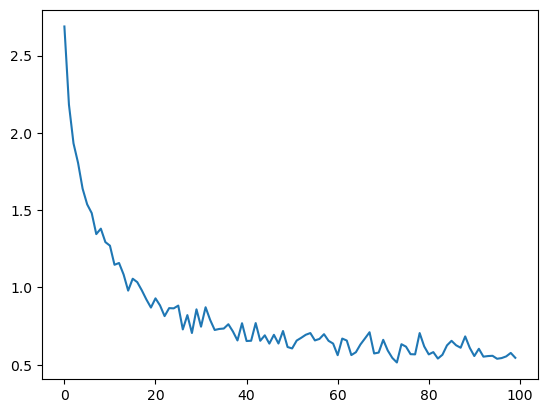

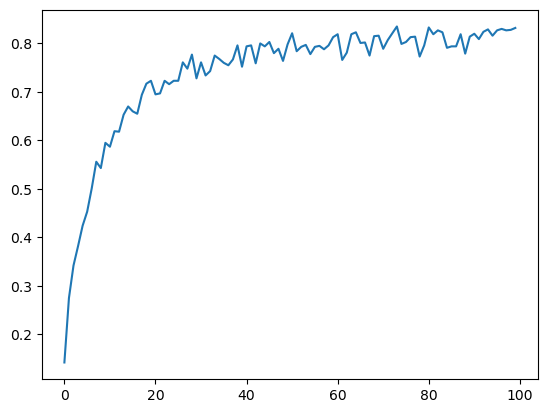

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

plt.figure()
plt.plot(all_accurancy)

C:\Users\86151\AppData\Local\Temp\ipykernel_10808\1609076396.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\86151\AppData\Local\Temp\ipykernel_10808\1609076396.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


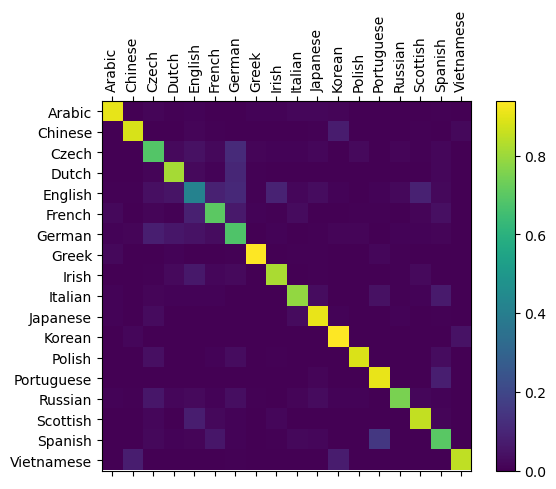

In [41]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    output = rnn(line_tensor)
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [21]:
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()
 
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
 
    def forward(self, x, 
                init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
 
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [23]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [24]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [25]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Scottish / line = Muir
category = Spanish / line = Felix
category = Italian / line = Romagna
category = Korean / line = Chi
category = Dutch / line = Kikkert
category = French / line = Jordan
category = Korean / line = Hung
category = French / line = Lebeau
category = Vietnamese / line = Thai
category = Japanese / line = Sasakawa


In [26]:
criterion = nn.NLLLoss()

In [27]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [28]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_accurancy = []
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [29]:
start = time.time()
correct_num = 0
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        correct_num += 1
        
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accurancy.append(correct_num / plot_every)
        correct_num = 0

5000 5% (0m 8s) 1.7241 Chellos / Greek ✓
10000 10% (0m 17s) 0.9393 Salvatici / Italian ✓
15000 15% (0m 26s) 0.3371 Strilakos / Greek ✓
20000 20% (0m 35s) 1.5946 Mach / Vietnamese ✓
25000 25% (0m 44s) 0.9312 Luc / Vietnamese ✓
30000 30% (0m 53s) 2.3341 Ingersleben / Dutch ✗ (German)
35000 35% (1m 1s) 0.6340 Kubota / Japanese ✓
40000 40% (1m 10s) 2.3601 Kerr / German ✗ (Scottish)
45000 45% (1m 19s) 1.8511 Tadhg / Japanese ✗ (Irish)
50000 50% (1m 28s) 0.6539 Donnchadh / Irish ✓
55000 55% (1m 36s) 1.0885 Kwak / Korean ✓
60000 60% (1m 45s) 0.7561 Xiong / Chinese ✓
65000 65% (1m 54s) 2.2067 Roth / Scottish ✗ (German)
70000 70% (2m 2s) 2.1824 Lightfoot / Russian ✗ (English)
75000 75% (2m 11s) 0.6557 Ferro / Portuguese ✓
80000 80% (2m 20s) 0.5353 Tolbert / French ✓
85000 85% (2m 29s) 0.1138 Yasutake / Japanese ✓
90000 90% (2m 37s) 4.6768 Dunn / Vietnamese ✗ (English)
95000 95% (2m 46s) 1.2454 Belanger / German ✗ (French)
100000 100% (2m 54s) 0.3653 Seo / Korean ✓


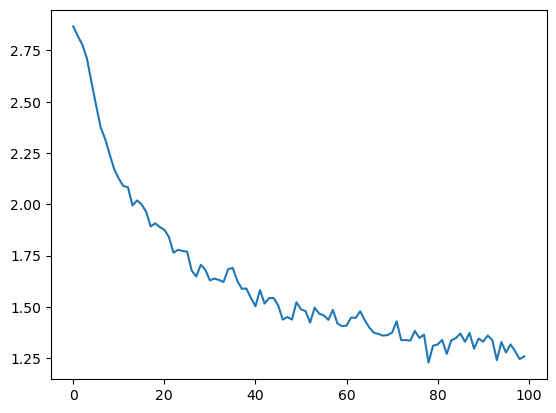

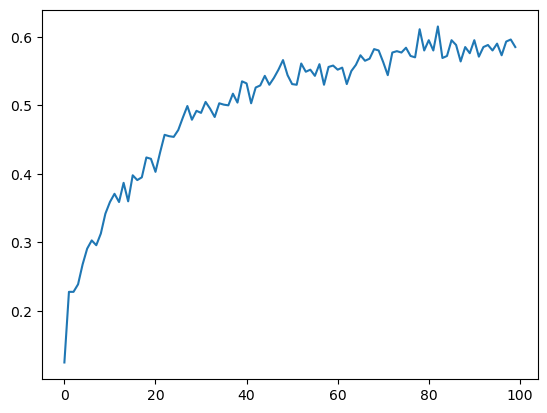

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

plt.figure()
plt.plot(all_accurancy)

C:\Users\86151\AppData\Local\Temp\ipykernel_10808\481346306.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\86151\AppData\Local\Temp\ipykernel_10808\481346306.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


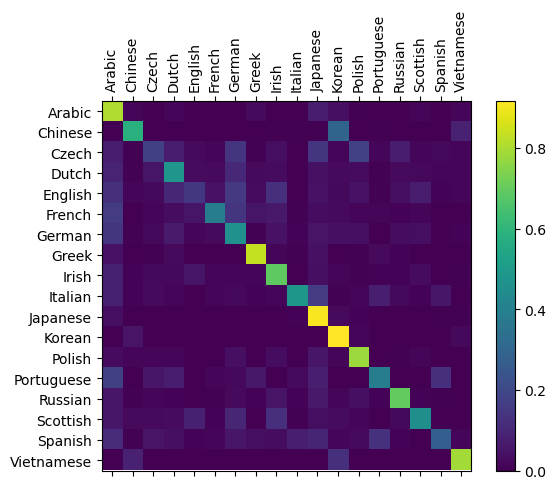

In [31]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [32]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        # print(input_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = (self.linear(out[-1]))
        out = self.softmax(out)
        return out

In [33]:
rnn = LSTM(n_letters, n_hidden, n_categories)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.005)
print(rnn)

LSTM(
  (lstm): LSTM(57, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [34]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_accurancy = []
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [35]:

def train(category_tensor, line_tensor):
    optimizer.zero_grad()
    output = rnn(line_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()


In [36]:
start = time.time()
correct_num = 0
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        correct_num += 1
        
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accurancy.append(correct_num / plot_every)
        correct_num = 0

5000 5% (0m 34s) 1.6352 Mclean / French ✗ (Scottish)
10000 10% (1m 9s) 1.3308 Fuchs / German ✓
15000 15% (1m 43s) 0.5068 Shaw / Scottish ✓
20000 20% (2m 19s) 0.1373 Romijn / Dutch ✓
25000 25% (2m 55s) 0.1419 Hughes / Scottish ✓
30000 30% (3m 35s) 0.0610 Balabuev / Russian ✓
35000 35% (4m 10s) 0.1157 Fraser / Scottish ✓
40000 40% (4m 45s) 0.0036 Xydis / Greek ✓
45000 45% (5m 21s) 0.7165 Asis / Spanish ✓
50000 50% (5m 56s) 0.7187 Shuai / Chinese ✓
55000 55% (6m 31s) 3.7877 Uchida / Czech ✗ (Japanese)
60000 60% (7m 7s) 5.6559 Jordan / Polish ✗ (French)
65000 65% (7m 42s) 1.6440 Mann / English ✗ (German)
70000 70% (8m 17s) 0.0153 Huie / Chinese ✓
75000 75% (8m 53s) 0.0001 Bellandini / Italian ✓
80000 80% (9m 28s) 0.0036 Zini / Italian ✓
85000 85% (10m 3s) 0.2167 Marion / French ✓
90000 90% (10m 39s) 3.9479 Janda / Spanish ✗ (Polish)
95000 95% (11m 15s) 0.2729 Opp / Czech ✓
100000 100% (11m 51s) 0.0010 Cousineau / French ✓


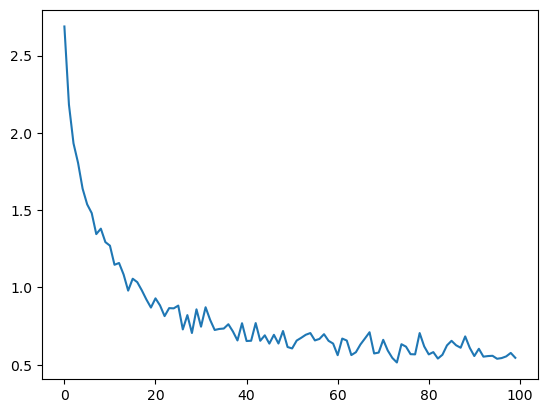

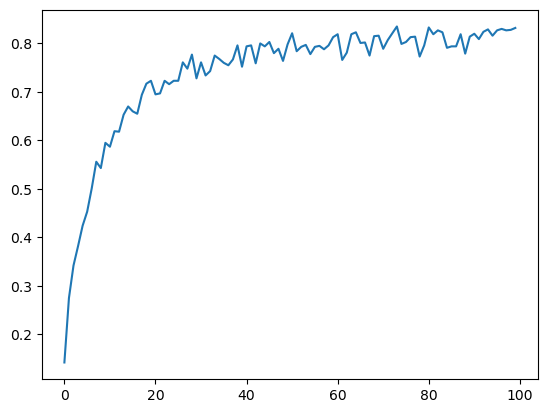

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

plt.figure()
plt.plot(all_accurancy)

C:\Users\86151\AppData\Local\Temp\ipykernel_10808\1609076396.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\86151\AppData\Local\Temp\ipykernel_10808\1609076396.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


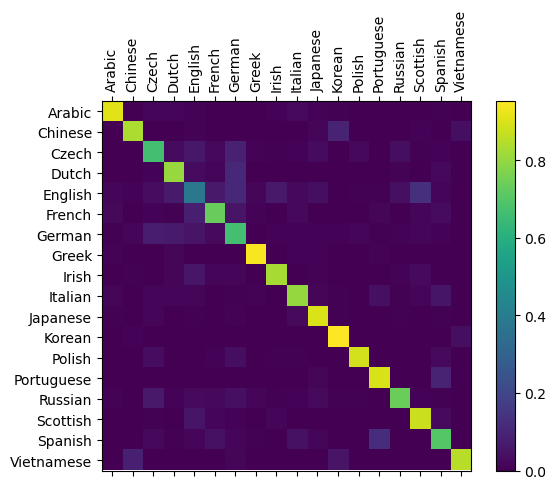

In [38]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    output = rnn(line_tensor)
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()